# Workbook for Knoxville, TN Metro Area

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
current_palette = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import time_series_conversion as ts
import plotting as pl
import dataframe_column_manipulation as dm
from IPython.display import clear_output
sns.set_style('darkgrid')

### Obtain

#### Loading Zillow Data

In [2]:
# Data that goes back to 4-1996
df_median_price = pd.read_csv('zillow_data.csv')
# Recent data that only goes back 2010 of number sales
df_count = pd.read_csv('Sale_Counts_Zip.csv', encoding='latin-1')

### Scrub

#### Removing Columns from dataframes

In [3]:
df_median_price = df_median_price.drop(columns='RegionID')
df_count= df_count.drop(columns=['RegionID','SizeRank', 'StateName', 'seasAdj'])

#### Filtering out the Metro Area

In [4]:
metro_area = 'Knoxville'

df = df_median_price.loc[df_median_price.Metro == metro_area]



#### Melting the Time Series Data into to the older 

In [5]:
data = ts.melt_data(df, name='Median_Home_Price')
data.head()

,RegionName,City,State,Metro,CountyName,SizeRank,Median_Home_Price
Time,,,,,,,
1996-04-01,37918,Knoxville,TN,Knoxville,Knox,871,77400.0
1996-04-01,37920,Knoxville,TN,Knoxville,Knox,1068,63100.0
1996-04-01,37919,Knoxville,TN,Knoxville,Knox,2098,136400.0
1996-04-01,37922,Knoxville,TN,Knoxville,Knox,2294,177500.0
1996-04-01,37830,Oak Ridge,TN,Knoxville,Anderson,2376,83000.0


#### Merging Sales Count and Median Sales 
-Joined based on zip code and month.  
-Non matching data from median sales were kept with NaN values for the sales counts.

In [6]:
df = pd.DataFrame([df_count.loc[df_count.RegionName == zip].to_dict('records')[0] for zip in df.RegionName.unique()]
)
df.RegionName = df.RegionName.astype(int)
df = ts.melt_data(df, name='Sales_Count', id_vars='RegionName')

data = data.merge(df, how = 'left', on=['Time','RegionName'])
data = data.rename(columns={'RegionName':'ZipCode'})
data.head()

,ZipCode,City,State,Metro,CountyName,SizeRank,Median_Home_Price,Sales_Count
Time,,,,,,,,
1996-04-01,37918,Knoxville,TN,Knoxville,Knox,871,77400.0,NaN
1996-04-01,37920,Knoxville,TN,Knoxville,Knox,1068,63100.0,NaN
1996-04-01,37919,Knoxville,TN,Knoxville,Knox,2098,136400.0,NaN
1996-04-01,37922,Knoxville,TN,Knoxville,Knox,2294,177500.0,NaN
1996-04-01,37830,Oak Ridge,TN,Knoxville,Anderson,2376,83000.0,NaN


#### Grouping Data by Month 
-Taking the mean median home price for a the zip codes in each time period.

In [7]:
df_total = data.groupby('Time')['Median_Home_Price'].mean()

### Explore

#### Determine the municapality that has the most zip codes.  

There are 3 multiple zip code municipalities. Knoxville is the most with 14, and smaller cities in neighboring county make up the other two, Maryville (3), and Lenoir City (2). Maryville, the next largest, is located south of Knoxville and close to the airport and has a small liberal arts college that bares its name. Lenoir City is southwest and has a wide geography area, but it is quite narrow because city expansion along state route TN-321, a main thru fare with many businesses. The rest (38) have only one zip code. 

In [8]:
data['2017'].City.value_counts()/12

Knoxville         14.0
Maryville          3.0
Lenoir City        2.0
Corryton           1.0
Andersonville      1.0
Pioneer            1.0
Farragut           1.0
Sunbright          1.0
Loudon             1.0
Townsend           1.0
Walland            1.0
Rockwood           1.0
Friendsville       1.0
Maynardville       1.0
Jacksboro          1.0
Lake City          1.0
Louisville         1.0
Luttrell           1.0
Lancing            1.0
Jellico            1.0
Caryville          1.0
Oliver Springs     1.0
Greenback          1.0
Alcoa              1.0
Blaine             1.0
Philadelphia       1.0
Kingston           1.0
Clinton            1.0
Washburn           1.0
Powell             1.0
Heiskell           1.0
Deer Lodge         1.0
Sharps Chapel      1.0
Harriman           1.0
Rockford           1.0
Oakdale            1.0
Lafollette         1.0
Oak Ridge          1.0
Mascot             1.0
Wartburg           1.0
Rutledge           1.0
Name: City, dtype: float64

#### Finding the sales counts of the zip codes  using 2017 information

In 2017, the top ten zip code by number sales (597–997 sales) were spread among four municipalities, Knoxville with seven of the top zip codes and Maryville, Oak Ridge, and Farragut with one each. Knoxville is by far the largest city in the area. Oak Ridge and Farragut are both suburbs west of Knoxville. Farragut is an affluent town in the same county as Knoxville (Knox County). Oak Ridge is farther northwest of Knoxville, and boasts large federal nuclear facilities and national laboratory that provides the major industry for the city and is important for the entire area. The rest of the zip codes trail off in size with twenty one of the lowest zip codes with less than 100 sales in 2017.

In [9]:
data['2017'].groupby(['City', 'State', 'ZipCode'])['Sales_Count'].sum().sort_values(ascending=False)[:10]

City       State  ZipCode
Knoxville  TN     37918      997.0
                  37922      797.0
                  37920      792.0
Maryville  TN     37803      780.0
Knoxville  TN     37919      683.0
                  37921      654.0
Oak Ridge  TN     37830      647.0
Knoxville  TN     37917      630.0
                  37923      624.0
Farragut   TN     37934      597.0
Name: Sales_Count, dtype: float64

In [10]:
data['2017'].groupby(['City', 'State', 'ZipCode'])['Sales_Count'].sum().sort_values(ascending=False)[-21:]

City           State  ZipCode
Friendsville   TN     37737      94.0
Rutledge       TN     37861      87.0
Caryville      TN     37714      80.0
Andersonville  TN     37705      71.0
Lake City      TN     37769      69.0
Walland        TN     37886      68.0
Philadelphia   TN     37846      48.0
Rockford       TN     37853      46.0
Wartburg       TN     37887      45.0
Mascot         TN     37806      44.0
Heiskell       TN     37754      36.0
Sharps Chapel  TN     37866      35.0
Luttrell       TN     37779      35.0
Lancing        TN     37770      33.0
Pioneer        TN     37847      31.0
Deer Lodge     TN     37726      31.0
Blaine         TN     37709      29.0
Jellico        TN     37762      26.0
Sunbright      TN     37872      26.0
Oakdale        TN     37829      24.0
Washburn       TN     37888      24.0
Name: Sales_Count, dtype: float64

#### Graphing Price for the Individual Zip Codes

Looking at pricing trends, most the zip codes follow the same general pattern. There is steady growth from the mid 1990's to the 2007–2008 recession where most pricing decreased . A pricing trough developed post 2009 and into the early 2010's followed by a return to steady growth to the present.

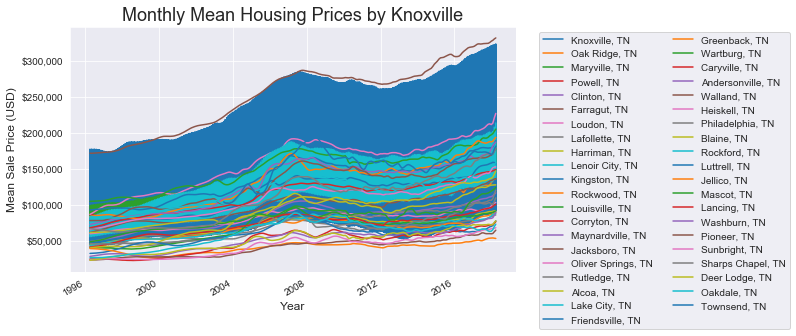

In [11]:
for city in data.City.unique():
    temp_df = data[data.City == city]
    ax = temp_df['Median_Home_Price'].plot(figsize=(8,5), label=f"{temp_df.City[0]}, {temp_df.State[0]}")
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mean Sale Price (USD)", fontsize=12)
new_dollar_scale = ax.get_yticks().astype(int).astype(str)
dollar_ticks = [new_dollar_scale[0]]
for tick in new_dollar_scale[1:]:
    try:
        dollar_ticks.append("$"+ tick[:-3]+ ","+ tick[-3:])
    except:
        continue
ax.set_yticklabels(dollar_ticks)
ax.set_title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=18);
plt.show()

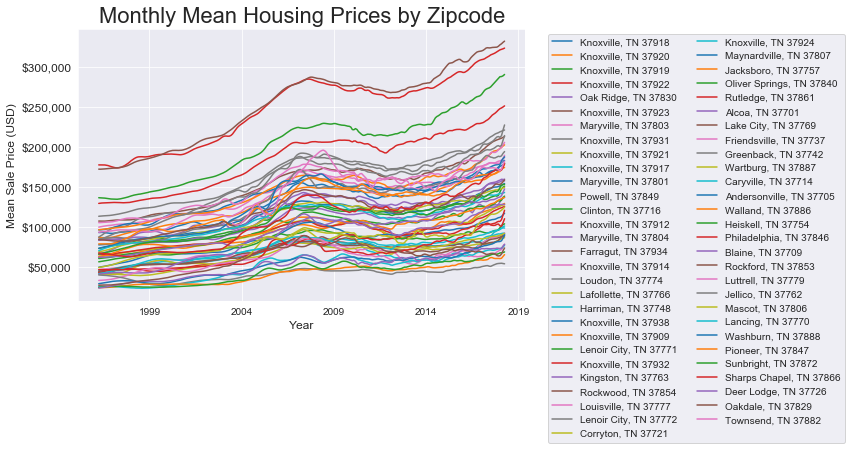

In [12]:
for zipcode in data.ZipCode.unique():
    temp_df = data.loc[data.ZipCode == zipcode]
    ax = temp_df['Median_Home_Price'].plot(figsize=(8,5), label=f"{temp_df.City[0]}, {temp_df.State[0]} {zipcode}")
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mean Sale Price (USD)", fontsize=12)
pl.dollar_tick(ax)
ax.set_title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=18);
plt.title("Monthly Mean Housing Prices by Zipcode", fontsize=22);

#### Analysis of the Effect of the 2008 Recession

All the zip codes experienced a drop in median home price ranging from 6.8% to 36.6% with an average of 15.6% . Although there were zip codes that have not recovered from the recession, most zip codes saw an increase from pre-recession highs with the average zip code 15.7% higher post crash. Even the non recovering zip codes are see a uptrend in the last five years

4 zip codes have not recovery from the 2008 crash.
15.7% is the average increase from the pre recession's high.
-15.6% is the average decrease in the recession.


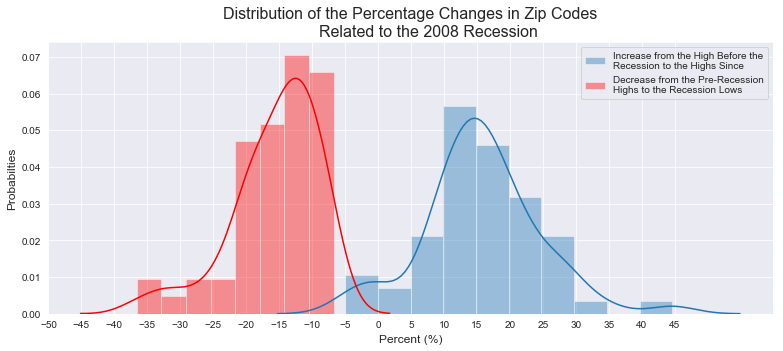

In [13]:
df_crash = dm.crash_analysis(data, plot=True)
plt.xticks(np.arange(-50, 50, step=5));
ax = plt.show()



In [14]:
df_crash.head()

,CrashHigh,CrashLoss,CrashLow,PostCrashHigh,Recovery,ZipCode
0,132300.0,-12.471655,115800.0,154200.0,16.553288,37918
1,107200.0,-18.936567,86900.0,129200.0,20.522388,37920
2,229500.0,-6.797386,213900.0,290700.0,26.666667,37919
3,284900.0,-8.353808,261100.0,323700.0,13.618814,37922
4,123600.0,-10.436893,110700.0,136900.0,10.760518,37830


In [15]:
print(f"{round(df_crash.CrashLoss.min(),1)}% to {round(df_crash.CrashLoss.max(),1)}%")
df_crash.sort_values('CrashLoss', ascending=False).head()

-36.6% to -6.8%


,CrashHigh,CrashLoss,CrashLow,PostCrashHigh,Recovery,ZipCode
15,287400.0,-6.750174,268000.0,332400.0,15.657620,37934
2,229500.0,-6.797386,213900.0,290700.0,26.666667,37919
23,208500.0,-7.673861,192500.0,251400.0,20.575540,37932
11,149600.0,-7.820856,137900.0,174300.0,16.510695,37849
12,128800.0,-8.074534,118400.0,150800.0,17.080745,37716


In [16]:
df_crash.sort_values('Recovery').head()

,CrashHigh,CrashLoss,CrashLow,PostCrashHigh,Recovery,ZipCode
38,96400.0,-24.066390,73200.0,91600.0,-4.979253,37887
55,89000.0,-28.651685,63500.0,86100.0,-3.258427,37829
46,85400.0,-32.903981,57300.0,84800.0,-0.702576,37779
56,196000.0,-25.918367,145200.0,196000.0,0.000000,37882
35,87500.0,-15.771429,73700.0,88500.0,1.142857,37769


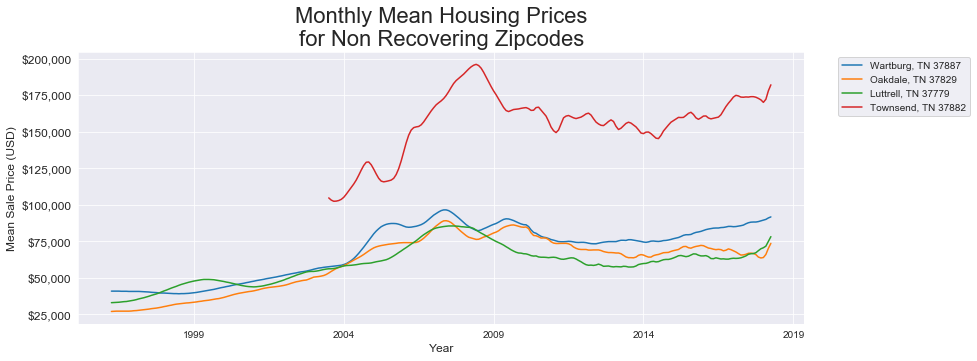

In [17]:
df_crash.sort_values('Recovery').iloc[:4].ZipCode

for zipcode in df_crash.sort_values('Recovery').iloc[:4].ZipCode:
    temp_df = data.loc[data.ZipCode == zipcode]
    ax = temp_df['Median_Home_Price'].plot(figsize=(13,5), label=f"{temp_df.City[0]}, {temp_df.State[0]} {zipcode}")
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mean Sale Price (USD)", fontsize=12)
pl.dollar_tick(ax)
ax.set_title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=18);
plt.title("Monthly Mean Housing Prices\nfor Non Recovering Zipcodes", fontsize=22);

#### Graphing Average by Time Period (Month)

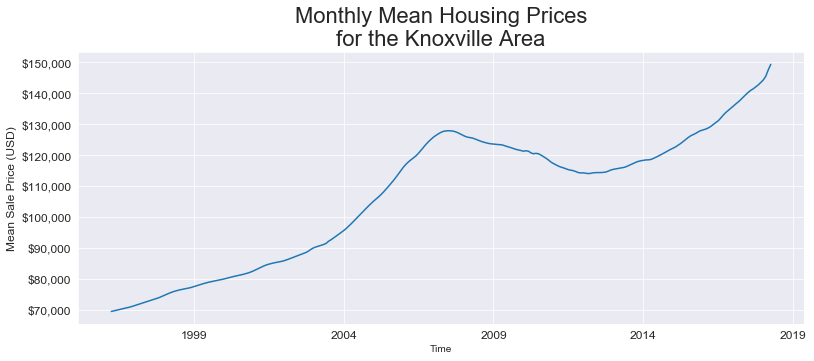

In [18]:
ax = df_total.plot(figsize=(13,5), label='Average for Knoxville\nMetro Area', fontsize=12)
ax.set_ylabel("Mean Sale Price (USD)", fontsize=12)
pl.dollar_tick(ax)
ax.set_title(f"Monthly Mean Housing Prices by {temp_df.Metro[0]}", fontsize=18);
plt.title("Monthly Mean Housing Prices\nfor the Knoxville Area", fontsize=22);
pre_crash_peak = df_total[:2009].sort_values()


In [19]:
df_total['2009':].idxmin()

Timestamp('2012-03-01 00:00:00')

### Model

#### SAMIRA Model (Data Averaged by Month) 

Selecting based on various options of AMIRA and SAMIRA parameters (pdqs and PDQs). 

Model output is not optimal.

-Residuals are out of control at multiple points. 

-Q-Q plot indicates that residuals lack normality. 

-Mean Square is extremely large (64714.36). 

I will restrict the model time period to start at the lowest point after the recession started (March 2012).

In [20]:
Current = ts.SAMIRA(df_total) 
print('Model Parameters\n',Current.set_parameters())
print(Current.summary())


Model Parameters
 pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           2946.18
Name: 59, dtype: object
                                 Statespace Model Results                                 
Dep. Variable:                  Median_Home_Price   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1469.091
Date:                            Thu, 05 Dec 2019   AIC                           2946.182
Time:                                    08:11:17   BIC                           2960.071
Sample:                                04-01-1996   HQIC                          2951.780
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

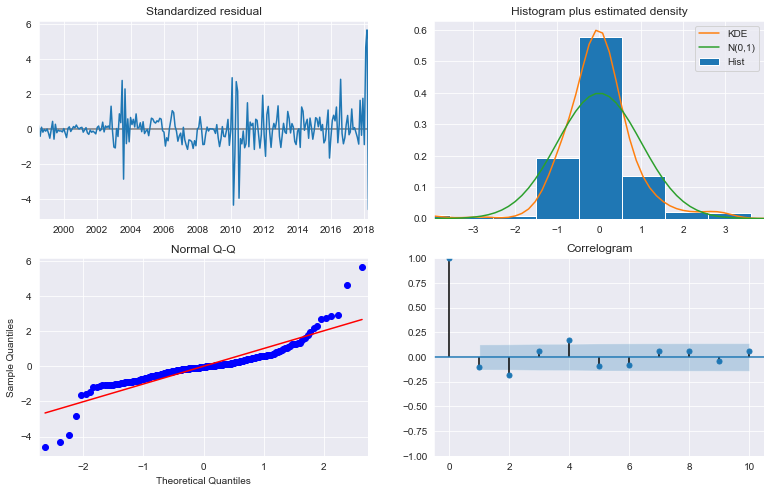

In [21]:
Current.diagnostics()

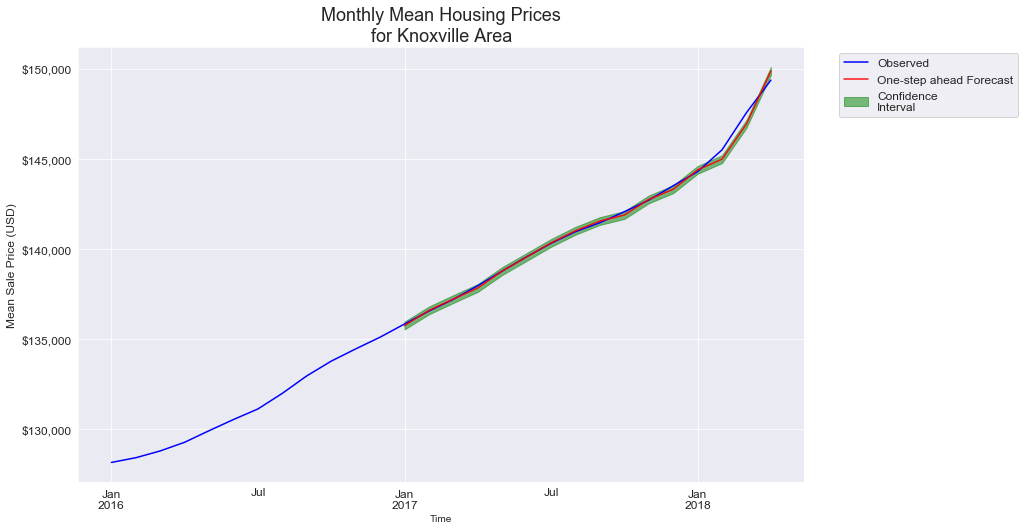

In [22]:
Current.validation(plot_year='2016', area='Knoxville Area')

#### SAMIRA Model (Data Averaged by Month) (Start Modeling at 2013)

Selecting based on various options of AMIRA and SAMIRA parameters (pdqs and PDQs). 

Model output is better.

-Residuals are **not** out of control at multiple points. 

-Q-Q plot indicates that residuals display kurtosis. 

-Mean Square is little smaller (62673.0). 

I will use this process to modelthe each indidvidual zip code

In [23]:

Current = ts.SAMIRA(df_total[df_total['2009':].idxmin():]) 
print('Model Parameters\n',Current.set_parameters())
print(Current.summary())


Model Parameters
 pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            623.21
Name: 59, dtype: object
                                 Statespace Model Results                                 
Dep. Variable:                  Median_Home_Price   No. Observations:                   74
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -307.605
Date:                            Thu, 05 Dec 2019   AIC                            623.210
Time:                                    08:11:32   BIC                            630.611
Sample:                                03-01-2012   HQIC                           625.995
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

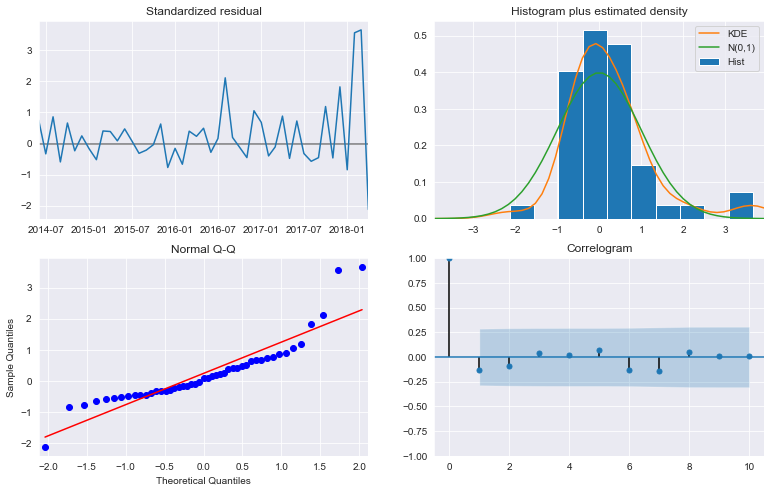

In [24]:
Current.diagnostics()


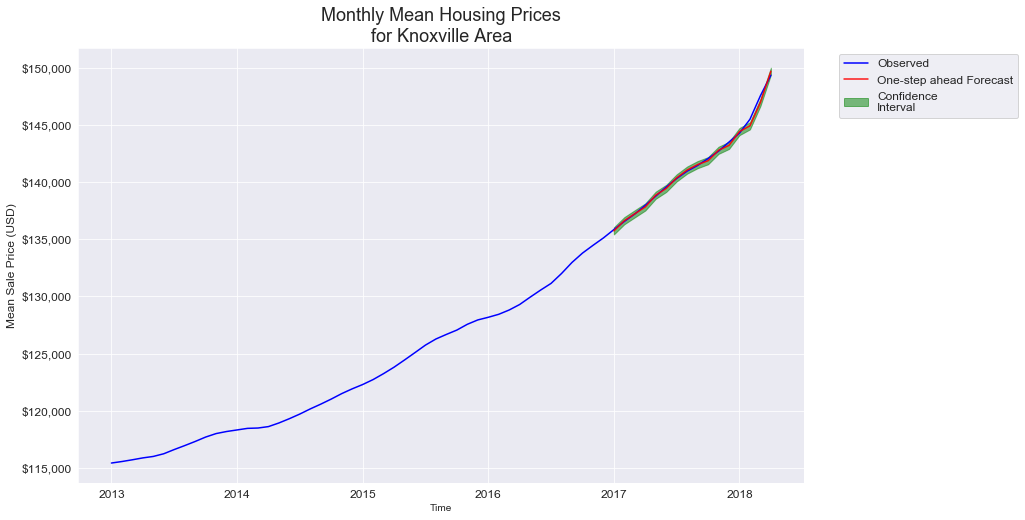

In [25]:
Current.validation(plot_year=df_total['2013':].idxmin(), area='Knoxville Area')

#### Selecting Individual Parameters for Each Zip Code (Starting Modeling at 2013)
I iteratied thru the individual zips the make up the Knoxville area and finding the parameters to beast fit each. 

**The result will be stored in a CSV file**

In [26]:
list_zip_parameters= []
list_models= []
mse_list_models = []
count= 0
for zipcode in data.ZipCode.unique():
    df = data.loc[data.ZipCode == zipcode].Median_Home_Price
    df = df['2013':]    
    pdq = ts.making_pdq(3, 3, 2)
    pdq = pdq[-2:]
    pdqs = ts.making_pdqs(2, 2, 2, 12)
    model = ts.SAMIRA(df)
    mse_check = 100000000
    aic_check = 100000
    zip_model = 0
    mse_zip_model = 0
    for comb in pdq:
        for combs in pdqs:
            dict_ = {'pdq':comb, 'pdqs':combs}
            try:
                model.load_parameter(dict_)
                
                if model.output.aic <= aic_check:
                    zip_model = model
                    aic_check = model.output.aic                 
            except:
                continue 
    zip_model.add_zip(zipcode)
    zip_model.roi()
    zip_model.validation(start_year='2017')
    list_models.append(zip_model)
    mse_list_models.append(mse_zip_model)
    count += 1
    clear_output()
    print(57-count, round(zip_model.mse), round(zip_model.output.aic))
    
df = pd.DataFrame([model.parameters for model in list_models])
df['ZipCode'] = [zipcode for zipcode in data.ZipCode.unique()]
df['label'] = [f"{data.loc[data.ZipCode == zipcode].City[0]}, TN {zipcode}" for zipcode in data.ZipCode.unique()]
df['ROI'] = [model.roi1*100 for model in list_models]
df.to_csv('zip_analysis_2013.csv')
top5 = [list_models[i] for i in df.sort_values('ROI').index[-5:]]


0 1564433.0 608.0


#### Remove Non Established Zip Code (less then 200 Sales in 2017)

In [39]:
df_zip = df.merge(data['2017':'2018'].groupby('ZipCode').sum(), on='ZipCode')
df_zip = df_zip.loc[df_zip.Sales_Count >= 200]
df_zip.index
top5 = [list_models[i] for i in df_zip.sort_values('ROI').index[-5:]]
df_zip.sort_values('ROI').iloc[-5:][['label', 'ROI']].head()

,label,ROI
27,"Lenoir City, TN 37772",13.059257
18,"Lafollette, TN 37766",14.287786
12,"Clinton, TN 37716",14.659930
22,"Lenoir City, TN 37771",15.016636
16,"Knoxville, TN 37914",20.149424


#### Filtering Out the Zip Codes with Top 5 ROIs Base on Dynamic Forcasting

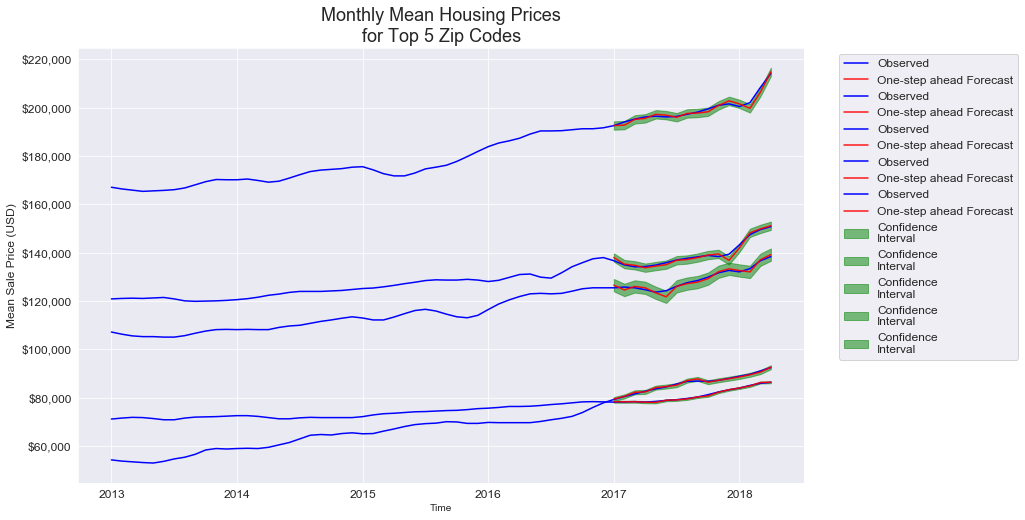

In [28]:
for model in top5:
    model.validation(plot_year='2013', area='Top 5 Zip Codes')
plt.show()

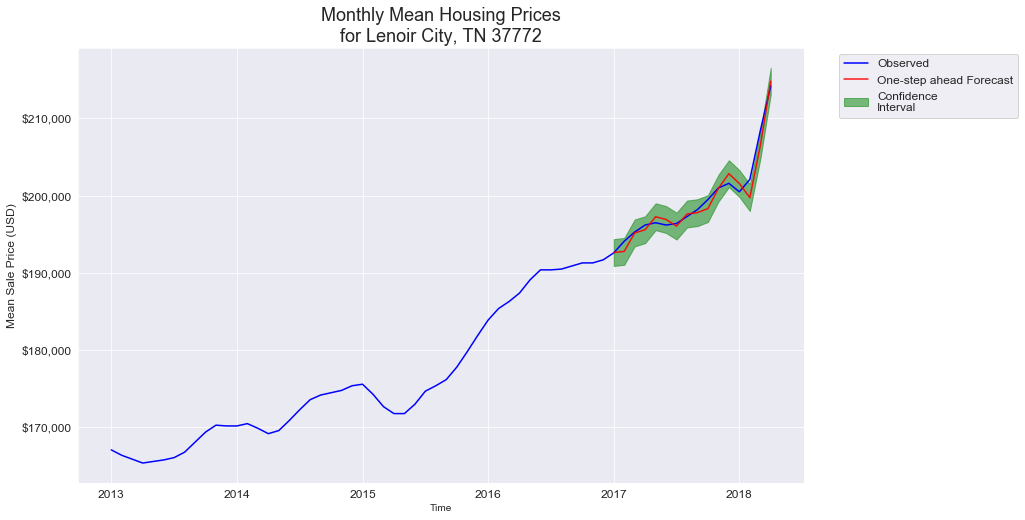

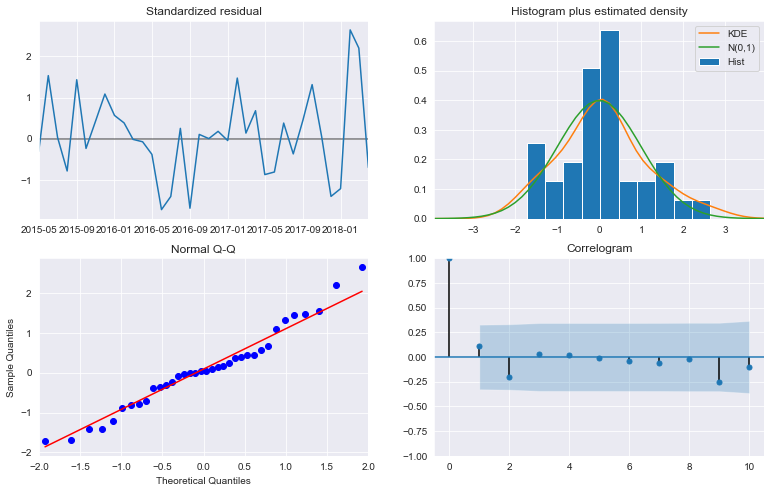

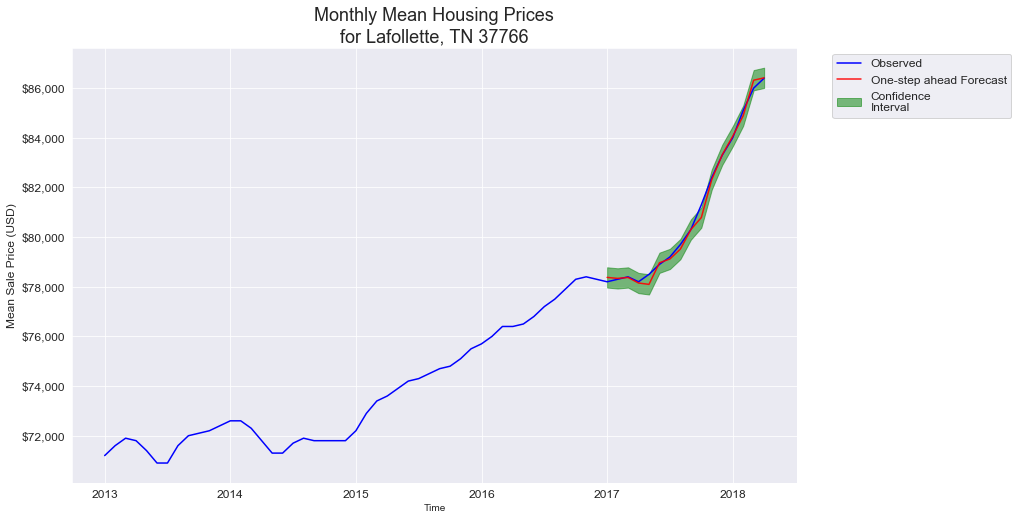

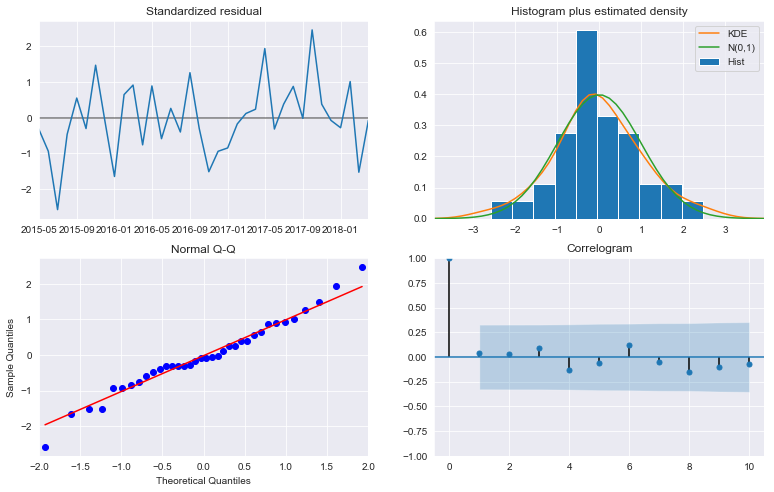

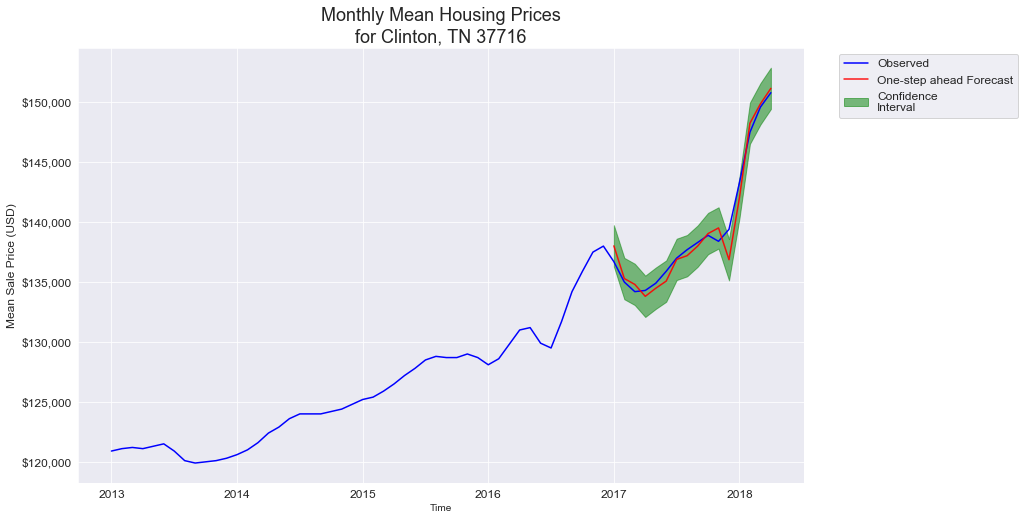

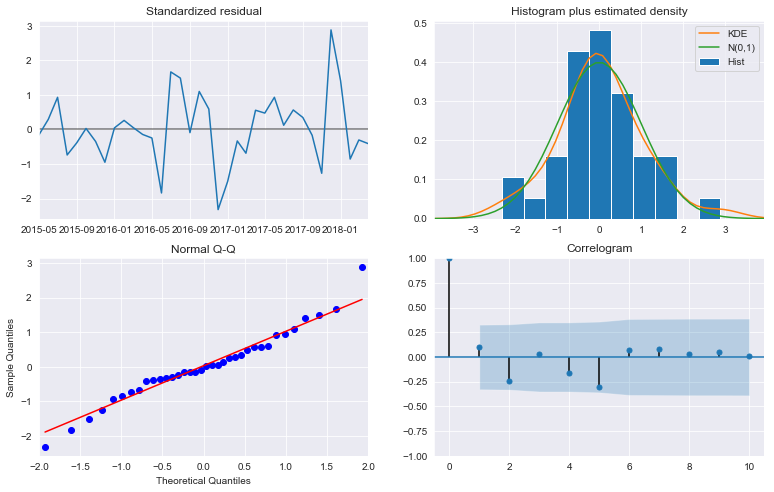

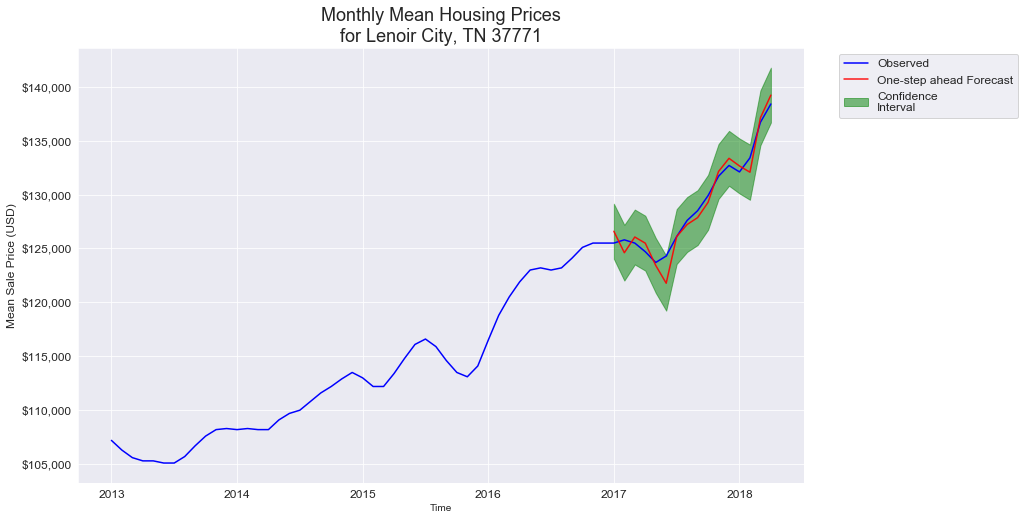

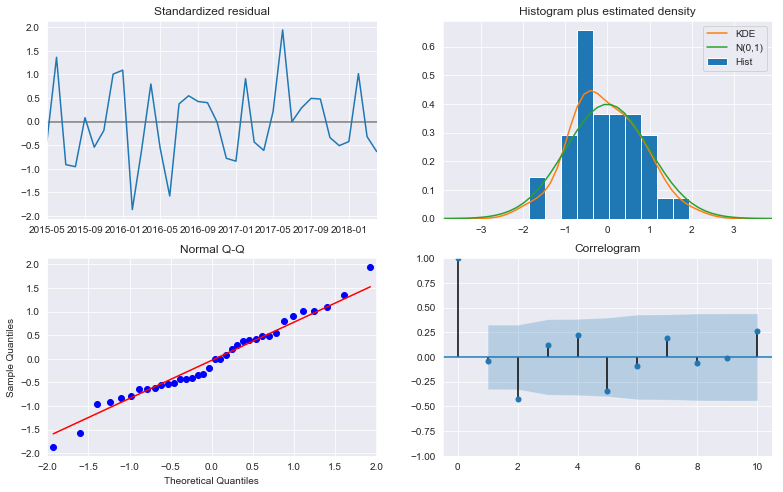

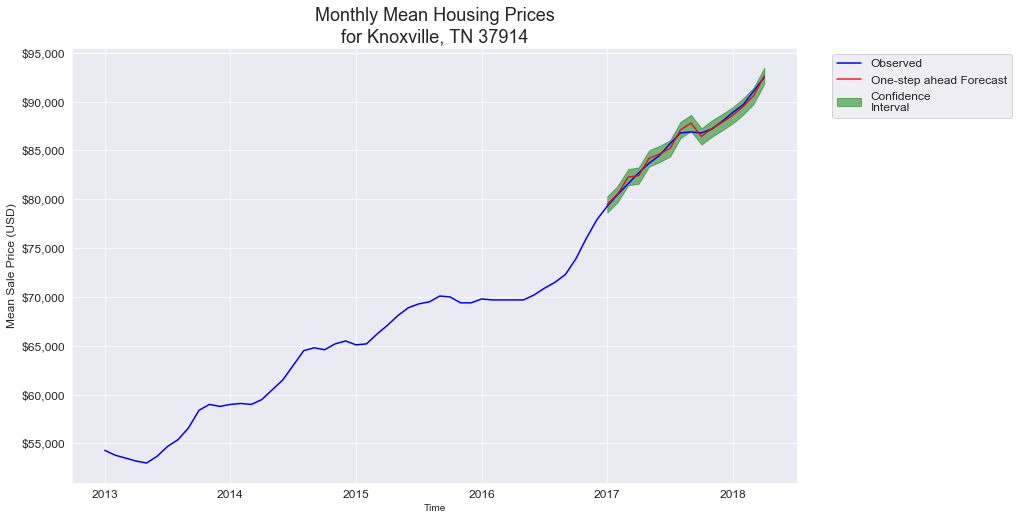

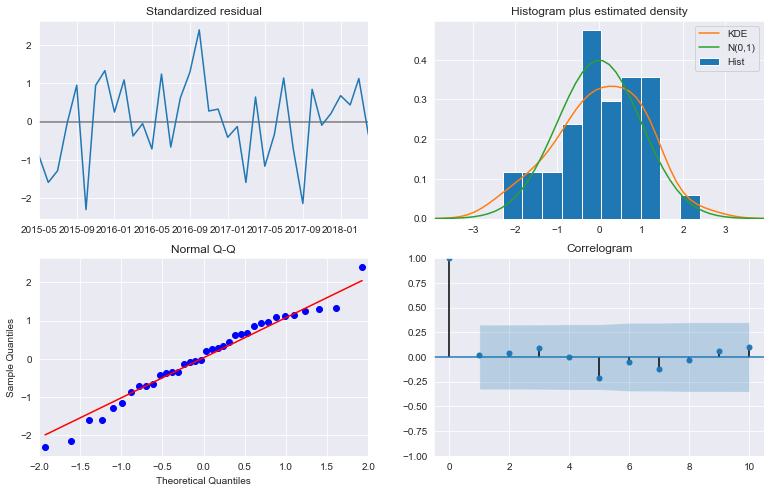

In [29]:
for model in top5:
    model.validation(plot_year='2013', area=df.loc[df.ZipCode == model.zip].label.unique()[0])
    plt.show()
    model.diagnostics()
    plt.show()
    
    
   

#### Predicting and Comparing Forecasted and Observed Values

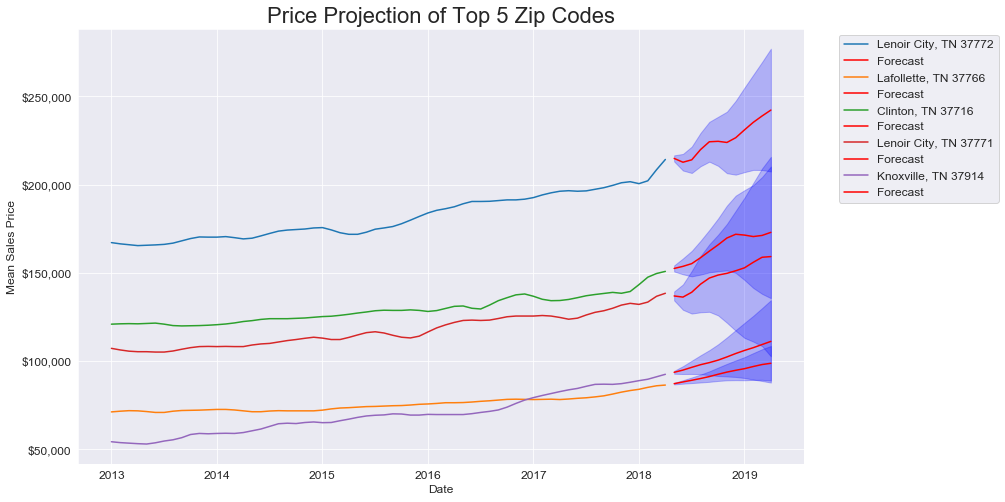

In [30]:
ax = 0
for model in top5:
    
    steps = 12
    prediction = model.output.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    pred_dict = {'Predicted':prediction.predicted_mean[-1],
                     'lower':pred_conf.iloc[-1][f'lower {model.time_series.name}'], 
                     'upper':pred_conf.iloc[-1][f'upper {model.time_series.name}'],
                     'Last': model.time_series[-1]}


    ax = model.time_series.plot(label=df.loc[df.ZipCode == model.zip].label.unique()[0], figsize=(13,8), fontsize=12)
    prediction.predicted_mean.plot(ax=ax, label='Forecast', color='r')
    ax.fill_between(pred_conf.index,
                            pred_conf.iloc[:, 0],
                            pred_conf.iloc[:, 1], color='blue', alpha=.25)
    ax.set_title(f"Price Projection of Top 5 Zip Codes",fontsize=22)
    ax.set_xlabel('Date',fontsize=12)
    ax.set_ylabel('Mean Sales Price',fontsize=12)
    pl.dollar_tick(ax)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)    
plt.show()

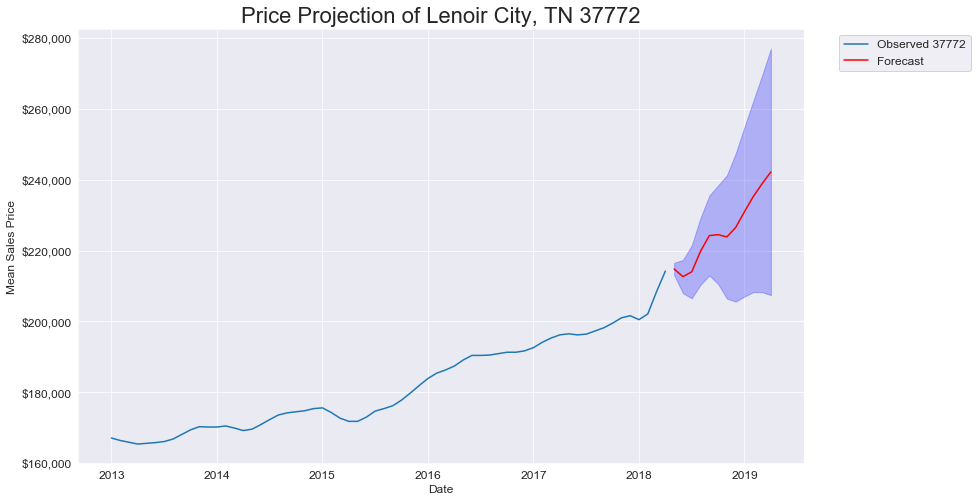

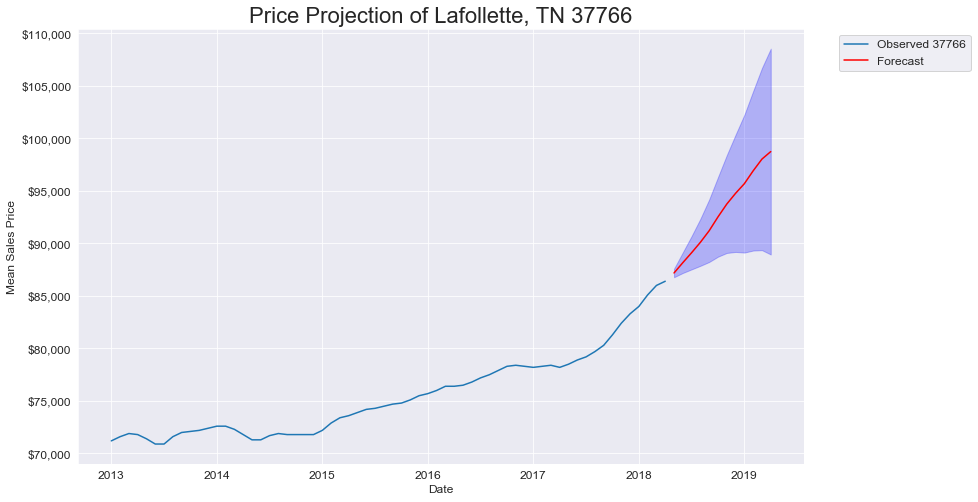

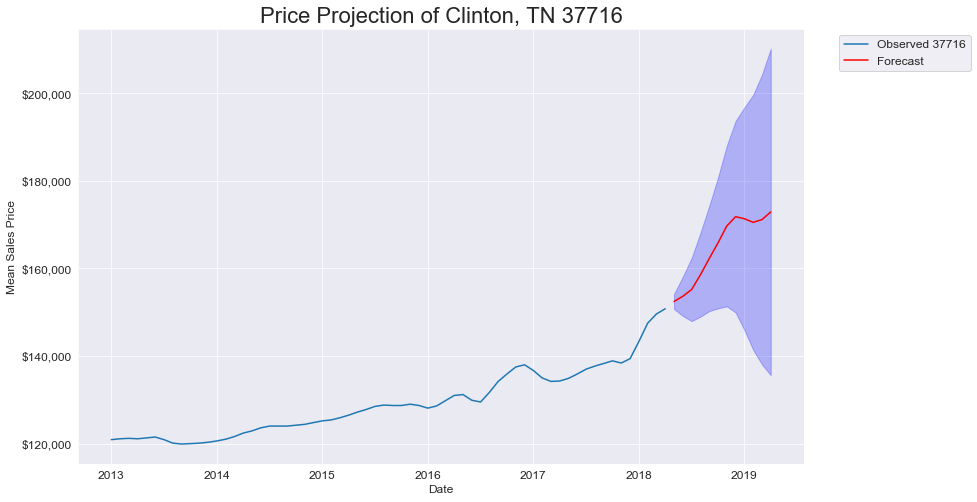

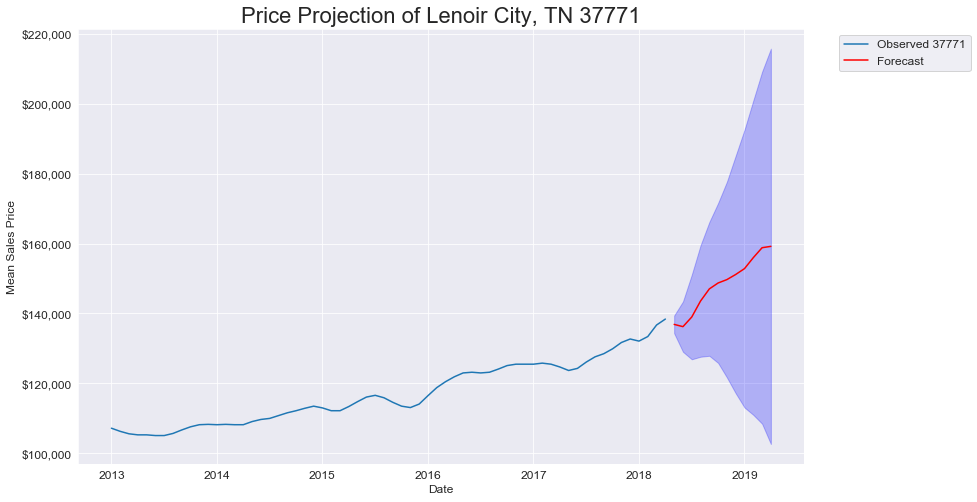

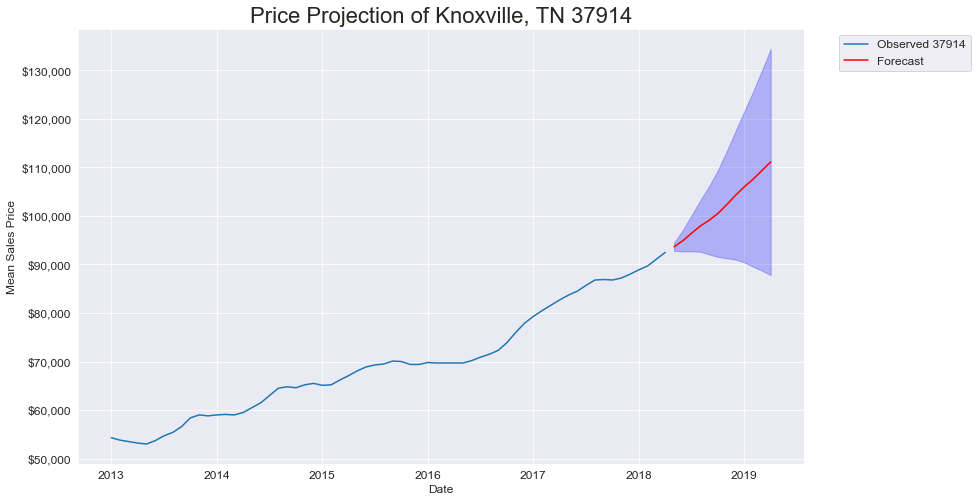

In [31]:
for model in top5:
    
    steps = 12
    prediction = model.output.get_forecast(steps=steps)
    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    pred_dict = {'Predicted':prediction.predicted_mean[-1],
                     'lower':pred_conf.iloc[-1][f'lower {model.time_series.name}'], 
                     'upper':pred_conf.iloc[-1][f'upper {model.time_series.name}'],
                     'Last': model.time_series[-1]}


    ax = model.time_series.plot(label=f'Observed {model.zip}', figsize=(13,8), fontsize=12)
    prediction.predicted_mean.plot(ax=ax, label='Forecast', color='r')
    ax.fill_between(pred_conf.index,
                            pred_conf.iloc[:, 0],
                            pred_conf.iloc[:, 1], color='blue', alpha=.25)
    ax.set_title(f"Price Projection of {df.loc[df.ZipCode == model.zip].label.unique()[0]}",fontsize=22)
    ax.set_xlabel('Date',fontsize=12)
    ax.set_ylabel('Mean Sales Price',fontsize=12)
    pl.dollar_tick(ax)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
    plt.show()


### Interpret

#### Removing Zips with Less than 200 Sales in 2017

In [32]:
dfa = df.merge(df_zip[['ZipCode', 'SizeRank']], on= 'ZipCode')
dfa = dfa.drop(columns='SizeRank')

#### Analyzing ROI Versus Multiple Measures

##### Post Crash High

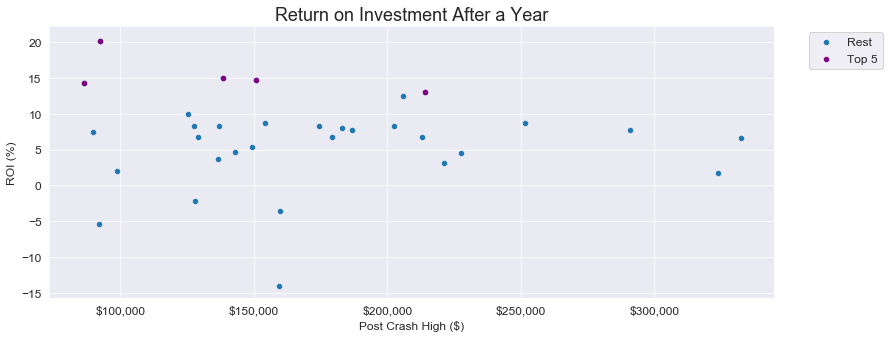

In [33]:
df_ = df_crash.merge(dfa, on='ZipCode')
ax = df_.plot.scatter(x='PostCrashHigh', y='ROI',figsize=(13,5), fontsize=12, label= 'Rest')
ax = df_.sort_values('ROI').iloc[-5:].plot.scatter(ax=ax, x='PostCrashHigh', y='ROI',label= 'Top 5',figsize=(13,5), 
                                                                              fontsize=12, color ='purple')
ax.set_title('Return on Investment After a Year',fontsize=18)
ax.set_xlabel('Post Crash High ($)',fontsize=12)
ax.set_ylabel('ROI (%)',fontsize=12)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
pl.dollar_tick(ax, y_axis=False)

##### Loss During Recession (%)

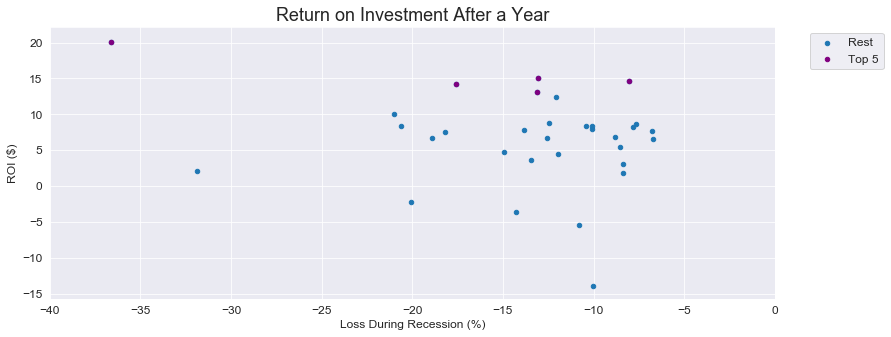

In [34]:

ax = df_.plot.scatter(x='CrashLoss', y='ROI', figsize=(13,5), fontsize=12, label='Rest')
df_.sort_values('ROI').iloc[-5:].plot.scatter(ax=ax, x='CrashLoss', y='ROI',label= 'Top 5',figsize=(13,5), 
                                                                              fontsize=12, color ='purple')
ax.set_title('Return on Investment After a Year', fontsize=18)
ax.set_xlabel('Loss During Recession (%)', fontsize=12)
ax.set_ylabel('ROI ($)', fontsize=12)
ax.set_xticks(np.arange(-40,5,5))
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
plt.show()

##### Recovery from Pre Recession High (%)

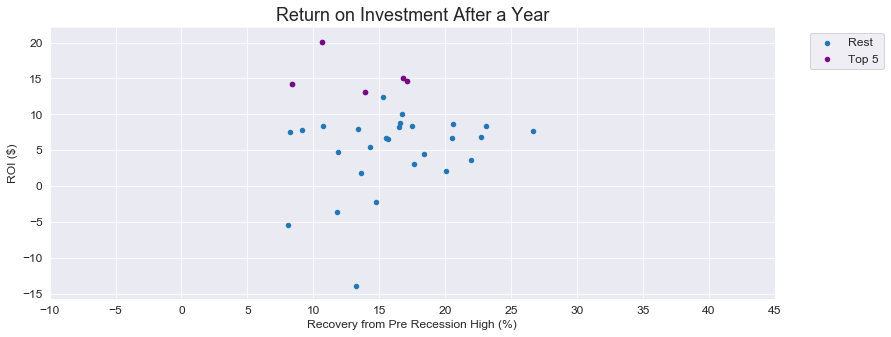

In [35]:
ax = df_.plot.scatter(x='Recovery', y='ROI', figsize=(13,5), fontsize=12, label='Rest')
df_.sort_values('ROI').iloc[-5:].plot.scatter(ax=ax, x='Recovery', y='ROI',label= 'Top 5',figsize=(13,5), 
                                                                              fontsize=12, color ='purple')
ax.set_title('Return on Investment After a Year', fontsize=18)
ax.set_xlabel('Recovery from Pre Recession High (%)',fontsize=12)
ax.set_ylabel('ROI ($)',fontsize=12)
ax.set_xticks(np.arange(-10,50,5))
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
plt.show()

##### Number of Homes Sold in 2017

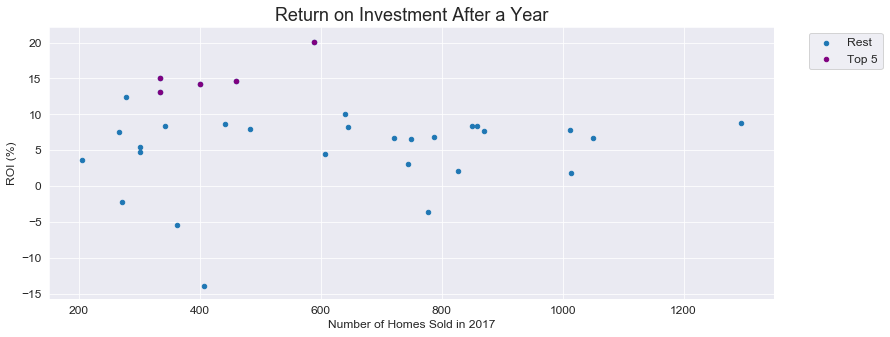

In [36]:
df_ = dfa.merge(data['2017':].groupby('ZipCode').sum(), on='ZipCode')

ax = df_.plot.scatter(x='Sales_Count', y='ROI', figsize=(13,5), fontsize=12, label='Rest')
df_.sort_values('ROI').iloc[-5:].plot.scatter(ax=ax, x='Sales_Count', y='ROI',label= 'Top 5',figsize=(13,5), 
                                                                              fontsize=12, color ='purple')
ax.set_title('Return on Investment After a Year', fontsize=18)
ax.set_xlabel('Number of Homes Sold in 2017', fontsize=12)
ax.set_ylabel('ROI (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
plt.show()

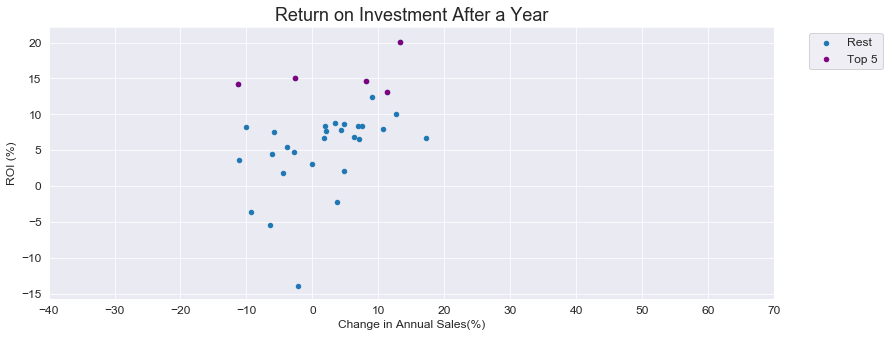

In [37]:
df_ = dfa.merge(data['2017-03-01':'2018-04-01'].groupby('ZipCode').sum(), on='ZipCode')
ds_2016 = dfa.merge(data['2016-03-01':'2017-04-01'].groupby('ZipCode').sum(), on='ZipCode')
df_= df_.merge(ds_2016, on='ZipCode')
df_['Change_in_Sales(%)'] = (df_.Sales_Count_x-df_.Sales_Count_y)*100/df_.Sales_Count_y     
ax = df_.plot.scatter(x='Change_in_Sales(%)', y='ROI_y', figsize=(13,5), fontsize=12, label='Rest')
df_.sort_values('ROI_y').iloc[-5:].plot.scatter(ax=ax, x='Change_in_Sales(%)', y='ROI_y',label= 'Top 5',figsize=(13,5), 
                                                                              fontsize=12, color ='purple')
ax.set_title('Return on Investment After a Year', fontsize=18)
ax.set_xlabel('Change in Annual Sales(%)', fontsize=12)
ax.set_ylabel('ROI (%)', fontsize=12)
ax.set_xticks(np.arange(-40,80,10))
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1,fontsize=12)
plt.show()

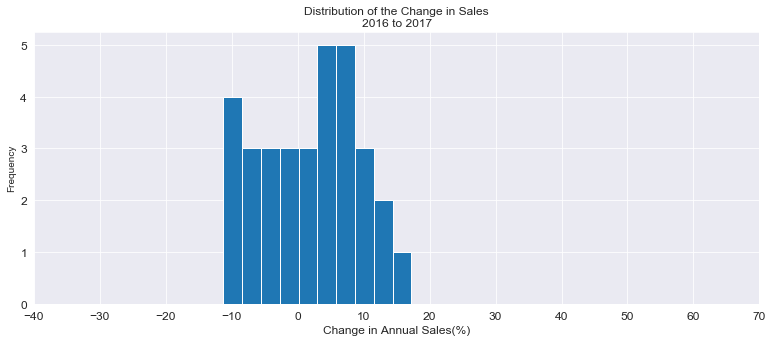

In [38]:
plt.figure(figsize=(13,5))
#sns.distplot(df_['Change_in_Sales(%)'])
df_['Change_in_Sales(%)'].plot.hist(fontsize=12)
plt.title('Distribution of the Change in Sales\n2016 to 2017', )
plt.xticks(np.arange(-40,80,10))
plt.xlabel('Change in Annual Sales(%)', fontsize=12)
plt.show()